# Workshop on Statistical Genetics and Genetic Epidemiology STAGE-Quebec
## Theme 2 - Molecular Phenotypes in Genetic Epidemiology

By Marc-André Legault (Université de Montréal) and Qihuang Zhang (McGill University)

**July 31 - August 1, 2025**

### Comparing TWAS Methodologies: S-PrediXcan vs FUSION

This notebook presents a comparative analysis examining how different TWAS (Transcriptome-Wide Association Study) methods can yield varying results when applied to the same dataset. Understanding these methodological differences is essential for interpreting TWAS findings and selecting appropriate analytical approaches for research applications.

**Analytical approach:**
We conducted parallel TWAS analyses of the same pancreatic gene expression data using two established methods:
- **S-PrediXcan**: Employing Elastic Net models with polygenicity adjustment
- **FUSION**: We focus on the included Elastic Net model for direct comparison

**Learning objectives:**
Upon completion of this notebook, participants will understand:
- How different TWAS methods can produce different results from identical data
- The impact of polygenicity calibration on statistical significance
- Criteria for evaluating the reliability of different approaches
- How to interpret comparative TWAS results in research contexts

The results files from the previous analyses are stored in the checkpoints directory and can be used to run this notebook.

In [50]:
library(ggplot2)

## Data Loading and Preparation

We will now load and prepare the results from both TWAS approaches for direct comparison. This process involves:

1. **Loading S-PrediXcan results**: Including both calibrated and uncalibrated statistics
2. **Loading FUSION results**: Filtering for Elastic Net models to match S-PrediXcan's approach
3. **Merging datasets**: Combining results by gene identifier for comparative analysis

We begin by loading the necessary visualization library and examining our data:

In [51]:
df_predixcan <- read.csv("results/twas_en_Pancreas.csv")

# We keep the uncalibrated TWAS statistics in a separate DF.
df_predixcan_uncal <- df_predixcan[, c("gene", "gene_name", "uncalibrated_zscore", "uncalibrated_pvalue", "pred_perf_r2")]
names(df_predixcan_uncal) <- c("ENSG", "gene_label", "Z_PREDIXCAN_NO_CALIB", "P_PREDIXCAN_NO_CALIB", "R2_PREDIXCAN")

df_predixcan <- df_predixcan[, c("gene", "gene_name", "zscore", "pvalue", "pred_perf_r2")]
names(df_predixcan) <- c("ENSG", "gene_label", "Z_PREDIXCAN", "P_PREDIXCAN", "R2_PREDIXCAN")
nrow(df_predixcan)

[1] 5879

In [52]:
df_fusion <- read.csv(
    "results/fusion_GTEx_pancreas.tsv",
    sep="\t",
    stringsAsFactors=F
)
# Keep only "enet" model which is the same penalized regression
# approach as for S-PrediXcan to maximize comparability.
df_fusion <- df_fusion[df_fusion$MODEL == "enet", ]
df_fusion <- df_fusion[, c("ID", "TWAS.Z", "TWAS.P", "MODELCV.R2")]
df_fusion <- df_fusion[complete.cases(df_fusion), ]
names(df_fusion) <- c("ENSG", "Z_FUSION", "P_FUSION", "R2_FUSION")
df_fusion$P_FUSION <- as.numeric(df_fusion$P_FUSION)
df_fusion$Z_FUSION <- as.numeric(df_fusion$Z_FUSION)

nrow(df_fusion)

Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


[1] 1478

In [47]:
merged_uncalibrated <- merge(df_predixcan_uncal, df_fusion, by="ENSG")
merged <- merge(df_predixcan, df_fusion, by="ENSG")
nrow(merged)

[1] 1058

## Comparative Analysis: Uncalibrated Results

We begin our comparison with the **uncalibrated** S-PrediXcan results versus FUSION. This comparison is particularly informative as it demonstrates the raw statistical output before any polygenicity adjustments.

**Key aspects of this comparison:**
- **Significance threshold**: Bonferroni correction applied (P ≤ 0.05 / 1,058 genes)
- **Color-coded regions**: The plot divides results into three interpretive zones
- **Direct methodology comparison**: Both methods use identical underlying Elastic Net models

The visualization below illustrates where the methods agree, disagree, and the implications for biological interpretation:

Warning message in geom_rect(aes(xmin = -Inf, xmax = p_thresh, ymin = p_thresh, :
“All aesthetics have length 1, but the data has 1058 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single row.”
Warning message in geom_rect(aes(xmin = p_thresh, xmax = Inf, ymin = p_thresh, ymax = Inf), :
“All aesthetics have length 1, but the data has 1058 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single row.”
Warning message in geom_rect(aes(xmin = p_thresh, xmax = Inf, ymin = -Inf, ymax = p_thresh), :
“All aesthetics have length 1, but the data has 1058 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single row.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


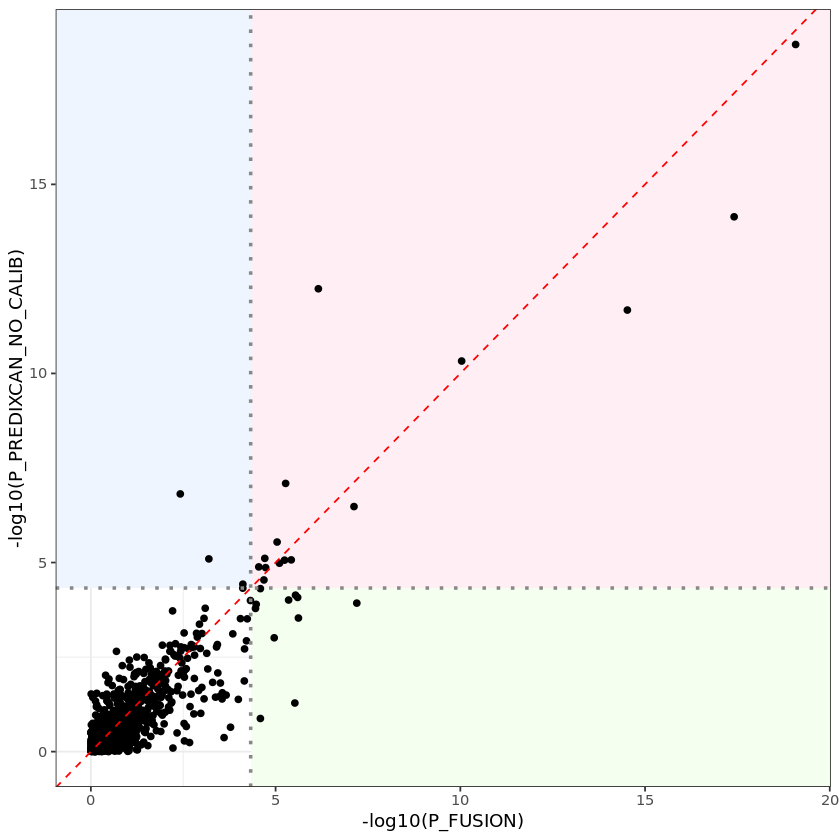

In [68]:
p_thresh <- -log10(0.05 / 1058)

ggplot(merged_uncalibrated, aes(x = -log10(P_FUSION), y = -log10(P_PREDIXCAN_NO_CALIB))) +
    geom_rect(aes(xmin = -Inf, xmax = p_thresh, ymin = p_thresh, ymax = Inf), 
              fill = "#eff5ff", inherit.aes = FALSE) +
    geom_rect(aes(xmin = p_thresh, xmax = Inf, ymin = p_thresh, ymax = Inf), 
              fill = "#ffeff5", inherit.aes = FALSE) +
    geom_rect(aes(xmin = p_thresh, xmax = Inf, ymin = -Inf, ymax = p_thresh), 
              fill = "#f5ffef", inherit.aes = FALSE) +
    geom_point() +
    geom_vline(xintercept = -log10(0.05 / 1058), linetype = "dotted", color = "#888888", size = 1) +
    geom_hline(yintercept = -log10(0.05 / 1058), linetype = "dotted", color = "#888888", size = 1) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
    theme_bw()

<div class="alert alert-info">    
<p><strong>Examine the three colored regions in the plot above:</strong></p>
    
<p><strong>Blue region (top-left):</strong> Genes significant only by S-PrediXcan
    <br /><strong>Pink region (top-right):</strong> Genes significant by both methods  
    <br /><strong>Green region (bottom-right):</strong> Genes significant only by FUSION</p>
    <p>
    <strong>Discussion questions:</strong>
    <ul>
        <li>What are the implications when a gene falls in each colored region?</li>
        <li>Why might two methods using the same underlying model produce different results?</li>
        <li>Which genes would provide the strongest evidence for follow-up studies?</li>
        <li>How can genes be significant in one method but not the other?</li>
    </ul>
    </p>
    <p><strong>Data exploration exercise:</strong> Use the data exploration cell below to identify specific examples:</p>
    <ul>
        <li>Identify a gene significant in both approaches (pink region)</li>
        <li>Find a gene significant only in FUSION (green region)</li>
        <li>Locate a gene significant only in S-PrediXcan (blue region)</li>
    </ul>
    <p><em>Consider examining genes with the most extreme differences between methods and their potential biological relevance to diabetes.</em></p>
</div>

In [72]:
# You can use this cell to explore the data!

## The Impact of Polygenicity Calibration

We now examine the comparison between **calibrated S-PrediXcan versus FUSION**. This analysis reveals the practical impact of S-PrediXcan's polygenicity adjustment—a methodological development designed to account for the polygenic nature of complex traits.

**Polygenicity calibration methodology:**
S-PrediXcan adjusts test statistics to account for the polygenic architecture of complex traits, where multiple genes simultaneously influence phenotypes such as diabetes. This calibration can substantially modify which genes appear statistically significant and aims to account for spurious associations.

**Expected effects:**
The calibration typically results in more conservative statistical inferences in S-PrediXcan, potentially reducing false positive associations while possibly increasing false negatives. The comparison below demonstrates how this adjustment affects our diabetes association results.

The following analysis examines how calibration transforms our results:

Warning message in geom_rect(aes(xmin = -Inf, xmax = p_thresh, ymin = p_thresh, :
“All aesthetics have length 1, but the data has 1058 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single row.”
Warning message in geom_rect(aes(xmin = p_thresh, xmax = Inf, ymin = p_thresh, ymax = Inf), :
“All aesthetics have length 1, but the data has 1058 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single row.”
Warning message in geom_rect(aes(xmin = p_thresh, xmax = Inf, ymin = -Inf, ymax = p_thresh), :
“All aesthetics have length 1, but the data has 1058 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single row.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


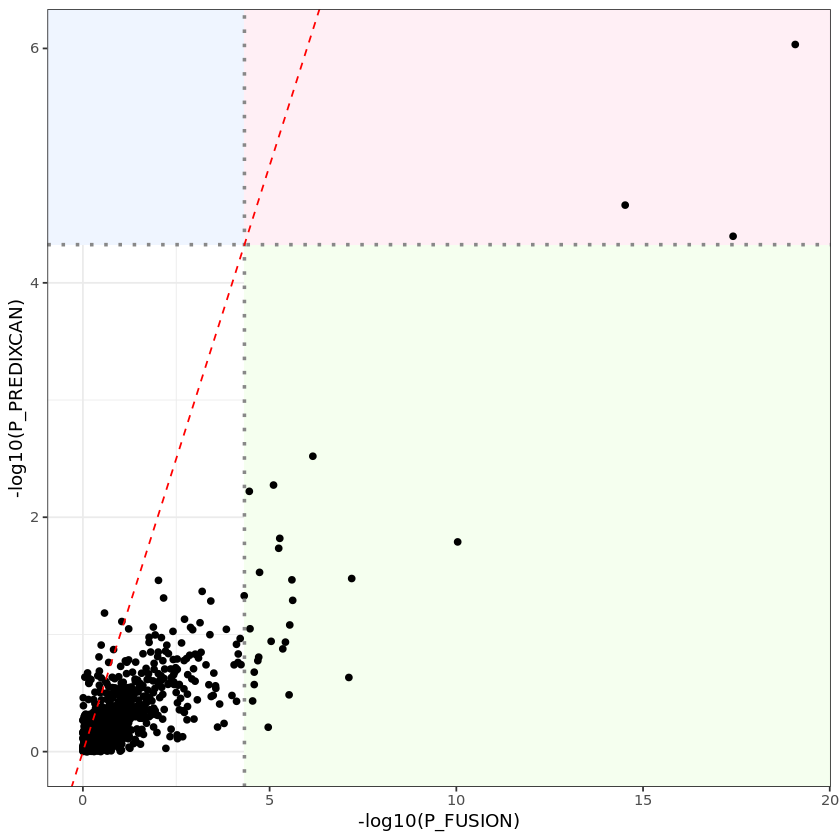

In [71]:
p_thresh <- -log10(0.05 / 1058)

ggplot(merged, aes(x = -log10(P_FUSION), y = -log10(P_PREDIXCAN))) +
    geom_rect(aes(xmin = -Inf, xmax = p_thresh, ymin = p_thresh, ymax = Inf), 
              fill = "#eff5ff", inherit.aes = FALSE) +
    geom_rect(aes(xmin = p_thresh, xmax = Inf, ymin = p_thresh, ymax = Inf), 
              fill = "#ffeff5", inherit.aes = FALSE) +
    geom_rect(aes(xmin = p_thresh, xmax = Inf, ymin = -Inf, ymax = p_thresh), 
              fill = "#f5ffef", inherit.aes = FALSE) +
    geom_point() +
    geom_vline(xintercept = p_thresh, linetype = "dotted", color = "#888888", size = 1) +
    geom_hline(yintercept = p_thresh, linetype = "dotted", color = "#888888", size = 1) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
    theme_bw()

<div class="alert alert-info">
    <h4>Key Analytical Questions:</h4>
    <ul>
        <li><strong>Magnitude of effect:</strong> To what extent does polygenicity adjustment modify the p-values?</li>
        <li><strong>Pattern of change:</strong> Are all genes affected uniformly, or do some exhibit more substantial shifts?</li>
        <li><strong>Methodological reliability:</strong> Given these differences, which approach provides more reliable identification of true gene-trait associations?</li>
        <li><strong>Practical considerations:</strong> How should these differences inform the selection of TWAS methodology?</li>
    </ul>
</div>

Answer here! You can also use another code cell to explore the data.